In [1]:
%matplotlib notebook
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv, lstsq

from poly_basis import *
from spherepts import *
from rbf import *

from math import *

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def L_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        r2 = dist(x,y)**2
        ret -= sigma*np.exp(-sigma*r2) * (4+r2*(-2+(-4+r2)*sigma))
    return ret
    
def sum_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        ret += np.exp(-sigma*dist(x,y)**2)
    return ret

def get_exact(harm_index):
    if harm_index is 'gaussians':
        sigmas = [2, .5, .3, .1, 5, 2, 1.5]
        ys = np.array([ [0,0,1],
                        [1,-1,1],
                        [2,0,1],
                        [-5,7,0],
                        [2,-13,1],
                        [2,12,-15],
                        [1,0,-1]], dtype=np.float)
        # project the centers onto the sphere
        for i, y in enumerate(ys):
            ys[i] = 1.0/norm(y)* y
        foo = lambda x: sum_gauss(x, sigmas, ys)
        exact = lambda x: L_gauss(x, sigmas, ys)
    else:
        # f is a spherical harmoic of degree below
        harm_index = 20

        sol_deg = sphere_harm_degs[harm_index]
        foo = lambda x: sphere_harm[harm_index](*x)
        exact = lambda x: -sol_deg*(sol_deg+1)*foo(x)
        print('Harmonic degree: %d' % sphere_harm_degs[harm_index])

    return foo, exact

In [4]:
n = 2000
k = 15
c = 100
rbf_obj = rbf_dict['multiquadric']
eps = 6
# foo, exact = get_exact('gaussians')
foo, exact = get_exact(10)

nodes = gen_spiral_nodes(n)
normals = nodes
tree = cKDTree(np.array(nodes))
stencil = tree.query(nodes[c], k)[1]
nn = nodes[stencil]

Harmonic degree: 4


<IPython.core.display.Javascript object>


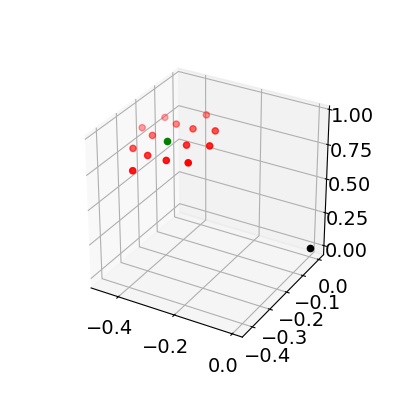

In [5]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nn[1:,0], nn[1:,1], nn[1:,2], '.', color='r')
ax.scatter(nn[0,0], nn[0,1], nn[0,2], '.', color='g')
ax.scatter(0, 0, 0, '.', color='k')

plt.show()

In [6]:
phi  = rbf_obj['rbf']
phi1 = rbf_obj['zeta']
phi2 = rbf_obj['chi']
phi3 = rbf_obj['beta']
phi4 = rbf_obj['gamma']
d2phi = rbf_obj['d2rbf']
def Gx(r, d, eps):
    return d*phi1(r,eps)
def Hx(r, d,eps):
    return phi1(r,eps) + d**2 * phi2(r,eps)
def GHx(r, d,eps):
    return 3*d*phi2(r,eps) + d**3 * phi3(r,eps)
def HHx(r, d,eps):
    return 3*phi2(r,eps) + 6 * d**2 * phi3(r,eps) + d**4 * phi4(r,eps)
def Lphi(r, eps):
    return 2*phi1(r,eps) + d2phi(r,eps)
def LG(r, d,eps):
    return 4*d*phi2(r,eps) + r**2 * d * phi3(r,eps)
def LH(r,d,eps):
    return 5*phi2(r,eps) + (r**2 + 7*d**2)*phi3(r,eps) + (d*r)**2 * phi4(r,eps)

In [7]:
r = dist_outer(nn,nn)
d = (nn - nn[0]) @ nn[0]
B = np.zeros((k,k+2))

B[:,:k] = Lphi(r, eps)
B[:,-2] = LG(r[0], d, eps)
B[:,-1] = LH(r[0], d, eps)

A = np.zeros((k+2,k+2))
A[:k, :k] = phi(r, eps)
A[:k, -2] = Gx(r[0], d, eps)
A[-2, :k] = -A[:k, -2]
A[:k, -1] = Hx(r[0], d, eps)
A[-1, :k] = A[:k, -1]
A[-2, -2] = -Hx(0, 0, eps)
A[-2, -1] = -GHx(0, 0, eps)
A[-1, -2] = -A[-2, -1]
A[-1, -1] = HHx(0, 0, eps)

print('cond(A) = %g' % np.log(cond(A)))
print('cond(phi(r))= %g' % np.log(cond(A[:k,:k])))

# C = (B @ la.inv(A))[:,:k]
C = la.solve(A.T, B.T).T[:,:k]

fs = np.array([foo(node) for node in nn])
ds = np.array([exact(node) for node in nn])

rel_error_L2  = la.norm(C@fs - ds)/la.norm(ds)
print('error: %g' % rel_error_L2)

cond(A) = 14.8045
cond(phi(r))= 9.5955
error: 1.14999


In [8]:
print(C@fs - ds)

[  7.13192742 -10.37773644   2.76720027  10.11418966  -9.58759823
  -5.35034421  26.8719631   35.53332065 -51.47680352 -99.78845551
  67.25102828  99.04076514  86.1160748   96.70857896 -45.78698706]
